In [17]:
import tensorflow as tf
from tensorflow import keras
import scipy
import scipy.io.wavfile as wav
import numpy as np
import wave
import matplotlib.pyplot as plt
import noisereduce
import speechpy
import os
from scipy.cluster.vq import vq, kmeans2, kmeans, whiten
from scipy.spatial import distance
from tqdm.notebook import tqdm
from hmmlearn import hmm
import ruptures as rpt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import soundfile as sf
import sounddevice as sd
import pickle 
from IPython.display import display
import pandas as pd
import random
import pyaudio
from scipy.io.wavfile import write
from sklearn.utils import shuffle
import IPython
IPython.display.Audio("my_audio_file.mp3")

ValueError: rate must be specified when data is a numpy array or list of audio samples.

In [9]:
testing_dir = os.getcwd()
testing_dir = os.path.join(testing_dir, '.\\TIMIT\\TEST')

training_dir = os.getcwd()
training_dir = os.path.join(training_dir, '.\\TIMIT\\TRAIN')



def load_phoneme_dataset(working_dir):
    phoneme_signals = {}
    dialect_folders = os.listdir(working_dir)
    for dialect_folder in tqdm(dialect_folders, leave=False):
        voice_folders = os.listdir(os.path.join(working_dir, dialect_folder))
        for voice_sample_folder in tqdm(voice_folders, leave=False):
            current_dir = os.path.join(working_dir, dialect_folder)
            current_dir = os.path.join(current_dir, voice_sample_folder)

            voice_samples = [file for file in os.listdir(current_dir) if file.endswith('.WAV')]
            for voice_sample in voice_samples:
                voice_sample_path = os.path.join(current_dir, voice_sample)
                signal, fs = sf.read(voice_sample_path)
#                 signal = np.zeros_like(signal)
#                 signal[40000] = 10
#                 print(signal.shape)
    
                # Pre-emphasize signal
                signal_preemphasized = speechpy.processing.preemphasis(signal, cof=0.98)

                # FFT
#                 frames = speechpy.processing.stack_frames(signal_preemphasized, sampling_frequency=fs, frame_length=0.02, frame_stride=0.01, zero_padding=True)
#                 fft = speechpy.processing.fft_spectrum(frames, 256)
    
#                 fig, ax = plt.subplots(nrows=2, ncols=1, constrained_layout=True)
#                 fig.supxlabel('Time')
#                 fig.set_size_inches(15, 10)
#                 ax[0].plot(signal_preemphasized)
#                 ax[0].set_xlim(0, signal_preemphasized.shape[0])
                
#                 fig.colorbar(ax[1].pcolor(fft.T))
                

                phoneme_transcript_path = os.path.join(current_dir, voice_sample)[:-3] + 'PHN'
                f = open(phoneme_transcript_path, encoding='utf-8')
                lines = f.readlines()
                for line in lines:
                    data = line.split(' ')
                    phoneme_start_idx = int(data[0])
                    phoneme_stop_idx = int(data[1])
                    phoneme = data[2].strip()
                    
#                     ax[0].axvline(x=phoneme_start_idx, color='red')
#                     ax[1].axvline(x=phoneme_start_idx/160, color='red')
                    
                    phoneme_signal_preemphasized = signal_preemphasized[int(phoneme_start_idx):int(phoneme_stop_idx)]

                
                    if phoneme in phoneme_signals:
#                         print(phoneme_fft)
                        phoneme_signals[phoneme].append(phoneme_signal_preemphasized)
                        
                    else:
                        phoneme_signals[phoneme] = []
                        phoneme_signals[phoneme].append(phoneme_signal_preemphasized)
#                     print(phoneme_signals[phoneme])
    return fs, phoneme_signals

try:
    training_phoneme_signals
except NameError:
    print('training phoneme signals hasn\'t been loaded yet')
    try:
        with open('training_phoneme_signals.pkl', 'rb') as handle:
            training_phoneme_signals = pickle.load(handle)
    except:
        print('training_phoneme_signals.pkl not found, start loading dataset')
        fs, training_phoneme_signals = load_phoneme_dataset(training_dir)
        with open('training_phoneme_signals.pkl', 'wb') as handle:
            pickle.dump(training_phoneme_signals, handle)
            
try:
    testing_phoneme_signals
except NameError:
    print('testing phoneme signals hasn\'t been loaded yet')
    try:
        with open('testing_phoneme_signals.pkl', 'rb') as handle:
            testing_phoneme_signals = pickle.load(handle)
    except:
        print('testing_phoneme_signals.pkl not found, start loading dataset')
        fs, testing_phoneme_signals = load_phoneme_dataset(testing_dir)
        with open('testing_phoneme_signals.pkl', 'wb') as handle:
            pickle.dump(testing_phoneme_signals, handle)

In [10]:
# words_list = [
#     ['c', 's iy'],
#     ['c', 's ih'],
#     ['d', 'd iy'],
#     ['d', 'd ih'],
#     ['h', 'hh eh ch'],
#     ['h', 'hh ey ch'],
#     ['h', 'eh ch'],
#     ['h', 'ey ch'],
#     ['k', 'k eh'],
#     ['k', 'k ey'],
#     ['n', 'eh n'],
#     ['o', 'ow'],
#     ['r', 'ah'],
#     ['r', 'ah r'],
#     ['s', 'eh s'],
#     ['v', 'v iy'],
#     ['v', 'v ih'],
#     ['z', 'z iy'],
#     ['z', 'z ih'],
#     ['z', 'z eh d'],
#     ['z', 's eh d']
# ]
keywords_list = [
    ['s', 's'],
    ['i', 'iy'],
    ['i', 'ih'],
    ['d', 'd'],
    ['h', 'hh'],
    ['e', 'eh'],
    ['e', 'ay'],
    ['ch', 'ch'],
    ['k', 'k'],
    ['n', 'n'],
    ['o', 'ow'],
    ['a', 'ah'],
    ['r', 'r'],
    ['v', 'v'],
    ['z', 'z'],
    ['silence', 'h#'],
]

for key in training_phoneme_signals.keys():
    found = False
    for phoneme_pair in keywords_list:
        if phoneme_pair[1] == key:
            found = True
        if found:
            break
    
    if not found:
        keywords_list.append(['other', key])
print(keywords_list, '\n')

unique_keywords = []
for phoneme_pair in keywords_list:
    if phoneme_pair[0] not in unique_keywords:
        unique_keywords.append(phoneme_pair[0])
print(unique_keywords)

[['s', 's'], ['i', 'iy'], ['i', 'ih'], ['d', 'd'], ['h', 'hh'], ['e', 'eh'], ['e', 'ay'], ['ch', 'ch'], ['k', 'k'], ['n', 'n'], ['o', 'ow'], ['a', 'ah'], ['r', 'r'], ['v', 'v'], ['z', 'z'], ['silence', 'h#'], ['other', 'sh'], ['other', 'ix'], ['other', 'hv'], ['other', 'dcl'], ['other', 'jh'], ['other', 'kcl'], ['other', 'ux'], ['other', 'q'], ['other', 'en'], ['other', 'gcl'], ['other', 'g'], ['other', 'w'], ['other', 'ao'], ['other', 'epi'], ['other', 'dx'], ['other', 'axr'], ['other', 'l'], ['other', 'y'], ['other', 'uh'], ['other', 'ae'], ['other', 'm'], ['other', 'oy'], ['other', 'ax'], ['other', 'dh'], ['other', 'tcl'], ['other', 'f'], ['other', 't'], ['other', 'pcl'], ['other', 'bcl'], ['other', 'b'], ['other', 'aa'], ['other', 'em'], ['other', 'ng'], ['other', 'th'], ['other', 'ax-h'], ['other', 'ey'], ['other', 'p'], ['other', 'aw'], ['other', 'er'], ['other', 'nx'], ['other', 'el'], ['other', 'uw'], ['other', 'pau'], ['other', 'zh'], ['other', 'eng']] 

['s', 'i', 'd', 'h', '

In [11]:
def plot_signal_array(signal_array):
    fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True)
    fig.supxlabel('Time')
    fig.set_size_inches(15, 5)
    ax.plot(signal_array)
    
def plot_pcolor(signal_array):
    fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True)
    fig.supxlabel('Time')
    fig.set_size_inches(15, 5)
    ax.pcolor(signal_array)

In [12]:
try:
    training_set
except NameError:
    print('training set hasn\'t been loaded yet')
    try:
        with open('training_set.pkl', 'rb') as handle:
            training_set = pickle.load(handle)

        with open('label_set.pkl', 'rb') as handle:
            label_set = pickle.load(handle)
    except:
        print('Cannot find training_set.pkl, start creating new dataset')
        training_set = []
        label_set = []

        signal_test, fs_test = sf.read('Recording.wav')
        signal_test = np.asarray([x[0] for x in signal_test])
        print(fs)
        for keyword in tqdm(keywords_list):
            count = 0
            phoneme = keyword[0]
            keyword = keyword[1]
            label = np.zeros(len(unique_keywords))
            label[unique_keywords.index(phoneme)] = 1
            for signal in tqdm(training_phoneme_signals[keyword]):
        #         print(signal[0], keyword)
        #         print(signal.shape)
        #         signal = training_phoneme_signals['s'][290]
        #         signal = np.concatenate((training_phoneme_signals['h#'][0], signal))
        #         signal = np.concatenate((signal,training_phoneme_signals['iy'][10]))
        #         signal = np.concatenate((signal, training_phoneme_signals['h#'][0]))
        #         plot_signal_array(signal)

        #         write('test.wav', fs, signal.astype(np.float32))
                if signal.shape[0] < 256:
                    continue
                try:
                    mfcc = speechpy.feature.mfcc(signal, sampling_frequency=fs, frame_length=0.020, frame_stride=0.01,
                                 num_filters=40, fft_length=256, low_frequency=0, high_frequency=None)
            #         mfcc_cmvn = speechpy.processing.cmvnw(mfcc,win_size=301,variance_normalization=True)
                    for frame in mfcc:
                        training_set.append(frame)
                        label_set.append(label)
                        count += 1
                except:
                    pass
        #         plot_pcolor(mfcc_cmvn.T)

        #         mfcc = speechpy.feature.mfcc(signal_test, sampling_frequency=fs_test, frame_length=0.020, frame_stride=0.01,
        #                      num_filters=40, fft_length=512, low_frequency=0, high_frequency=None)
        #         mfcc_cmvn = speechpy.processing.cmvnw(mfcc,win_size=301,variance_normalization=True)
        #         plot_pcolor(mfcc_cmvn[:200].T)

        #         break
        #     break
            audio_list = []

            print(keyword, count)
        with open('training_set.pkl', 'wb') as handle:
            pickle.dump(training_set, handle)

        with open('label_set.pkl', 'wb') as handle:
            pickle.dump(label_set, handle)

In [13]:
label_count = np.zeros(len(unique_keywords))
print(label_set[1])
for label in label_set:
    label_count[label.tolist().index(1)] += 1

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [14]:
print('Dataset counts:')
for x, y in zip(unique_keywords, label_count):
    print (x, int(y))

Dataset counts:
s 65999
i 73012
d 1393
h 3866
e 54131
ch 5086
k 13571
n 21277
o 21593
a 14798
r 23485
v 7156
z 22262
silence 155588
other 504274


In [15]:
import librosa

In [8]:
from sklearn.utils import shuffle

training_set, label_set = shuffle(training_set, label_set)

def add_random_noise(signal):
    percentage = 0.05
    noise = np.random.normal(0, signal.std(), signal.size) * percentage
    return signal + noise

target_dataset_count = 20000
balanced_training_set = []
balanced_training_label = []
for i, keyword in enumerate(tqdm(unique_keywords)):
    count = 0
    for j, label in enumerate(label_set):
        if label.tolist().index(1) == i:
            signal = training_set[j]
            balanced_training_set.append(signal)
            balanced_training_label.append(label_set[j])
            count += 1
        if count >= target_dataset_count:
            break
    if label_count[i] < target_dataset_count:
        remaining_count = target_dataset_count - label_count[i]
        idx = 0
        while remaining_count > 0:
            for j, label in enumerate(label_set):
                if label.tolist().index(1) == i:
                    signal = training_set[j]
                    signal = add_random_noise(signal)
                    balanced_training_set.append(signal)
                    balanced_training_label.append(label_set[j])
                    remaining_count -= 1
                if remaining_count <= 0:
                    break

  0%|          | 0/15 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x00000219D68DBEB0>
Traceback (most recent call last):
  File "C:\Users\user\miniconda3\lib\site-packages\tqdm\std.py", line 1162, in __del__
    self.close()
  File "C:\Users\user\miniconda3\lib\site-packages\tqdm\notebook.py", line 281, in close
    def close(self):
KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
balanced_label_count = np.zeros(len(unique_keywords))
for label in balanced_training_label:
    balanced_label_count[label.tolist().index(1)] += 1
    
print('Dataset counts:')
for x, y in zip(unique_keywords, balanced_label_count):
    print (x, int(y))

In [ ]:
with open('20k_training_set.pkl', 'wb') as handle:
    pickle.dump(balanced_training_set, handle)

with open('20k_training_label_set.pkl', 'wb') as handle:
    pickle.dump(balanced_training_label, handle)

In [ ]:
try:
    testing_set
except NameError:
    print('testing set hasn\'t been loaded yet')
    try:
        with open('testing_set.pkl', 'rb') as handle:
            testing_set = pickle.load(handle)

        with open('testing_label_set.pkl', 'rb') as handle:
            testing_label_set = pickle.load(handle)
    except:
        print('Cannot find testing_set.pkl, start creating new dataset')
        testing_set = []
        testing_label_set = []

        signal_test, fs_test = sf.read('Recording.wav')
        signal_test = np.asarray([x[0] for x in signal_test])
        print(fs)
        for keyword in tqdm(keywords_list):
            count = 0
            phoneme = keyword[0]
            keyword = keyword[1]
            label = np.zeros(len(unique_keywords))
            label[unique_keywords.index(phoneme)] = 1
            for signal in tqdm(testing_phoneme_signals[keyword]):
        #         print(signal[0], keyword)
        #         print(signal.shape)
        #         signal = training_phoneme_signals['s'][290]
        #         signal = np.concatenate((training_phoneme_signals['h#'][0], signal))
        #         signal = np.concatenate((signal,training_phoneme_signals['iy'][10]))
        #         signal = np.concatenate((signal, training_phoneme_signals['h#'][0]))
        #         plot_signal_array(signal)

        #         write('test.wav', fs, signal.astype(np.float32))
                if signal.shape[0] < 256:
                    continue
                try:
                    mfcc = speechpy.feature.mfcc(signal, sampling_frequency=fs, frame_length=0.020, frame_stride=0.01,
                                 num_filters=40, fft_length=256, low_frequency=0, high_frequency=None)
            #         mfcc_cmvn = speechpy.processing.cmvnw(mfcc,win_size=301,variance_normalization=True)
                    for frame in mfcc:
                        testing_set.append(frame)
                        testing_label_set.append(label)
                        count += 1
                except:
                    pass
        #         plot_pcolor(mfcc_cmvn.T)

        #         mfcc = speechpy.feature.mfcc(signal_test, sampling_frequency=fs_test, frame_length=0.020, frame_stride=0.01,
        #                      num_filters=40, fft_length=512, low_frequency=0, high_frequency=None)
        #         mfcc_cmvn = speechpy.processing.cmvnw(mfcc,win_size=301,variance_normalization=True)
        #         plot_pcolor(mfcc_cmvn[:200].T)

        #         break
        #     break
            audio_list = []

            print(keyword, count)
        with open('testing_set.pkl', 'wb') as handle:
            pickle.dump(testing_set, handle)

        with open('testing_label_set.pkl', 'wb') as handle:
            pickle.dump(testing_label_set, handle)

In [ ]:
testing_label_count = np.zeros(len(unique_keywords))
for label in testing_label_set:
    testing_label_count[label.tolist().index(1)] += 1
print('Dataset counts:')
for x, y in zip(unique_keywords, testing_label_count):
    print (x, int(y))

In [ ]:
testing_set, testing_label_set = shuffle(testing_set, testing_label_set)

target_dataset_count = 5000
balanced_testing_set = []
balanced_testing_label = []
for i, keyword in enumerate(tqdm(unique_keywords)):
    count = 0
    for j, label in enumerate(testing_label_set):
        if label.tolist().index(1) == i:
            signal = testing_set[j]
            balanced_testing_set.append(signal)
            balanced_testing_label.append(testing_label_set[j])
            count += 1
        if count >= target_dataset_count:
            break
    if testing_label_count[i] < target_dataset_count:
        remaining_count = target_dataset_count - testing_label_count[i]
        idx = 0
        while remaining_count > 0:
            for j, label in enumerate(testing_label_set):
                if label.tolist().index(1) == i:
                    signal = testing_set[j]
                    signal = add_random_noise(signal)
                    balanced_testing_set.append(signal)
                    balanced_testing_label.append(testing_label_set[j])
                    remaining_count -= 1
                if remaining_count <= 0:
                    break

In [ ]:
balanced_testing_label_count = np.zeros(len(unique_keywords))
for label in balanced_testing_label:
    balanced_testing_label_count[label.tolist().index(1)] += 1
    
print('Dataset counts:')
for x, y in zip(unique_keywords, balanced_testing_label_count):
    print (x, int(y))

In [ ]:
with open('5k_testing_set.pkl', 'wb') as handle:
    pickle.dump(balanced_testing_set, handle)

with open('5k_testing_label_set.pkl', 'wb') as handle:
    pickle.dump(balanced_testing_label, handle)

In [16]:
import datetime
testing_dir = os.getcwd()
testing_dir = os.path.join(testing_dir, '.\\TIMIT\\TEST')

training_dir = os.getcwd()
training_dir = os.path.join(training_dir, '.\\TIMIT\\TRAIN')



def create_phoneme_dataset(working_dir, prev_frames, future_frames):
    signals_list = []
    labels_list = []
    dialect_folders = os.listdir(working_dir)
    for dialect_folder in tqdm(dialect_folders, leave=False):
        voice_folders = os.listdir(os.path.join(working_dir, dialect_folder))
        for voice_sample_folder in tqdm(voice_folders, leave=False):
            current_dir = os.path.join(working_dir, dialect_folder)
            current_dir = os.path.join(current_dir, voice_sample_folder)

            voice_samples = [file for file in os.listdir(current_dir) if file.endswith('.WAV')]
            for voice_sample in voice_samples:
                voice_sample_path = os.path.join(current_dir, voice_sample)
                signal, fs = sf.read(voice_sample_path)

                # Pre-emphasize signal
#                 signal_preemphasized = speechpy.processing.preemphasis(signal, cof=0.98)
            
#                 mfcc = speechpy.feature.mfcc(signal, sampling_frequency=fs, frame_length=0.025, frame_stride=0.01,
#                                  num_filters=40, fft_length=256, low_frequency=0, high_frequency=None)

                current_signals_list = []
                current_labels_list = []
                phoneme_transcript_path = os.path.join(current_dir, voice_sample)[:-3] + 'PHN'
                f = open(phoneme_transcript_path, encoding='utf-8')
                lines = f.readlines()
                for line in lines:
                    data = line.split(' ')
                    phoneme_start_idx = int(data[0])
                    phoneme_stop_idx = int(data[1])
                    phoneme = data[2].strip()
                    
                    label = np.zeros(len(unique_keywords))
                    for phoneme_pair in keywords_list:
                        if phoneme_pair[1] == phoneme:
                            phoneme = phoneme_pair[0]
                            break
                    label[unique_keywords.index(phoneme)] = 1
                    
                    for frame in signal[int(phoneme_start_idx):int(phoneme_stop_idx)]:
                        current_signals_list.append(frame)
                        current_labels_list.append(label)
                        
                for i in range(len(current_signals_list)):
                    if i >= prev_frames and i < len(current_signals_list) - future_frames:
                        if i%100:
                            filename = f'./local_recordings/{unique_keywords[current_labels_list[i].tolist().index(1)]}-{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.wav'
                            sf.write(filename, current_signals_list[i - prev_frames: i + future_frames + 1], 16000)
                        signals_list.append(current_signals_list[i - prev_frames: i + future_frames + 1])
                        labels_list.append(unique_keywords[current_labels_list[i].tolist().index(1)])
                        
    return fs, signals_list, labels_list

fs, x_train_signal, y_train_signal = create_phoneme_dataset(testing_dir, 30*160, 10*160)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]


KeyboardInterrupt



In [26]:
label_count = np.zeros(len(unique_keywords))
for label in y_train:
    label_count[label.tolist().index(1)] += 1
    
print('Dataset counts:')
for x, y in zip(unique_keywords, label_count):
    print (x, int(y))

Dataset counts:
s 28706
i 34923
d 2314
h 1566
e 24015
ch 2127
k 7767
n 12898
o 7824
a 7466
r 15093
v 4077
z 10830
silence 17679
other 268242


In [31]:
def add_random_noise(signal):
    percentage = 0.05
    noise = np.random.normal(0, signal.std(), signal.shape) * percentage
    return signal + noise

x_train, y_train = shuffle(x_train, y_train)

target_dataset_count = 10000
x_train_balanced = []
y_train_balanced = []
for i, keyword in enumerate(tqdm(unique_keywords)):
    count = 0
    for j, label in enumerate(y_train):
        if label.tolist().index(1) == i:
            x_train_balanced.append(np.array(x_train[j]))
            y_train_balanced.append(np.array(y_train[j]))
            count += 1
        if count >= target_dataset_count:
            break
    if label_count[i] < target_dataset_count:
        remaining_count = target_dataset_count - label_count[i]
        idx = 0
        while remaining_count > 0:
            for j, label in enumerate(y_train):
                if label.tolist().index(1) == i:
                    signal = x_train[j]
                    signal = add_random_noise(np.array(signal))
                    x_train_balanced.append(np.array(signal))
                    y_train_balanced.append(np.array(y_train[j]))
                    remaining_count -= 1
                if remaining_count <= 0:
                    break
x_train_balanced = np.array(x_train_balanced)
y_train_balanced = np.array(y_train_balanced)

  0%|          | 0/15 [00:00<?, ?it/s]

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

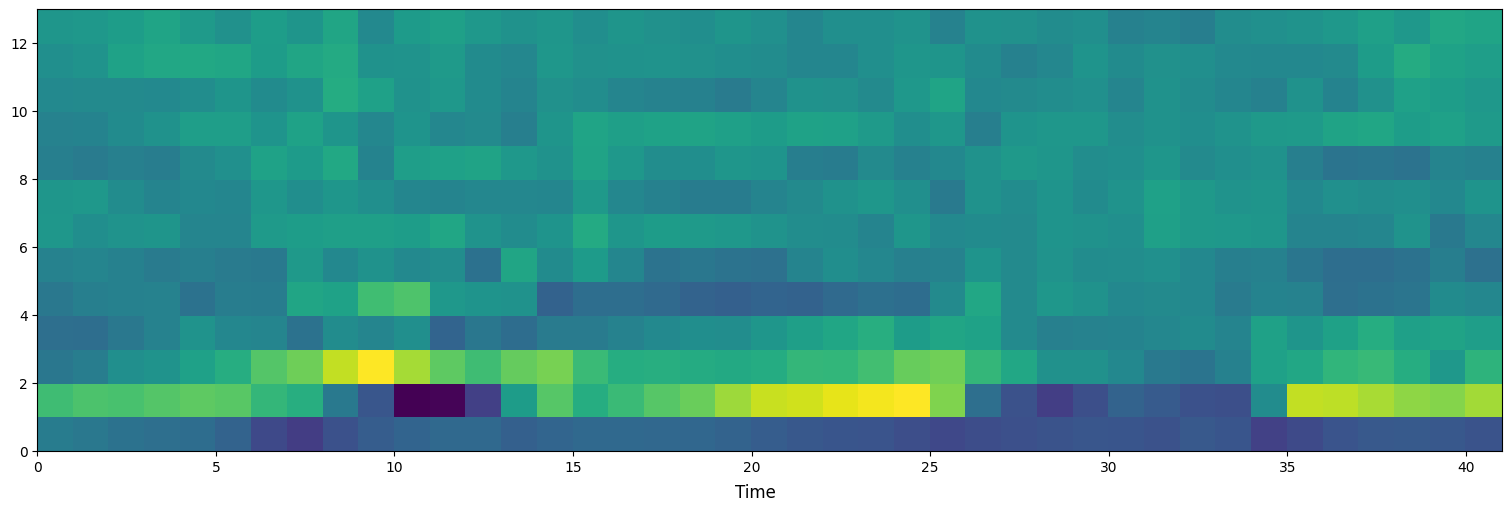

In [32]:
np.save('150k_x_test.npy', x_train_balanced)
np.save('150k_y_test.npy', y_train_balanced)

plot_pcolor(x_train_balanced[7].T)
y_train_balanced

In [30]:
x_train_balanced.shape

(75000, 41, 13)

LibsndfileError: Error opening './local_recordings/o.wav': System error.

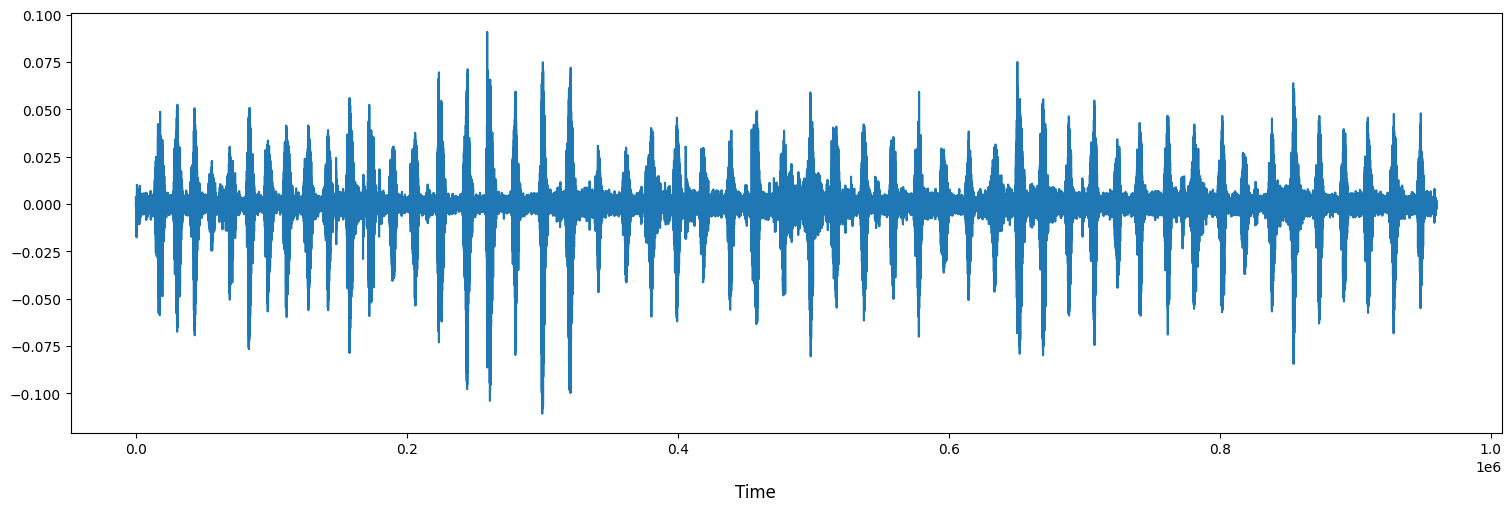

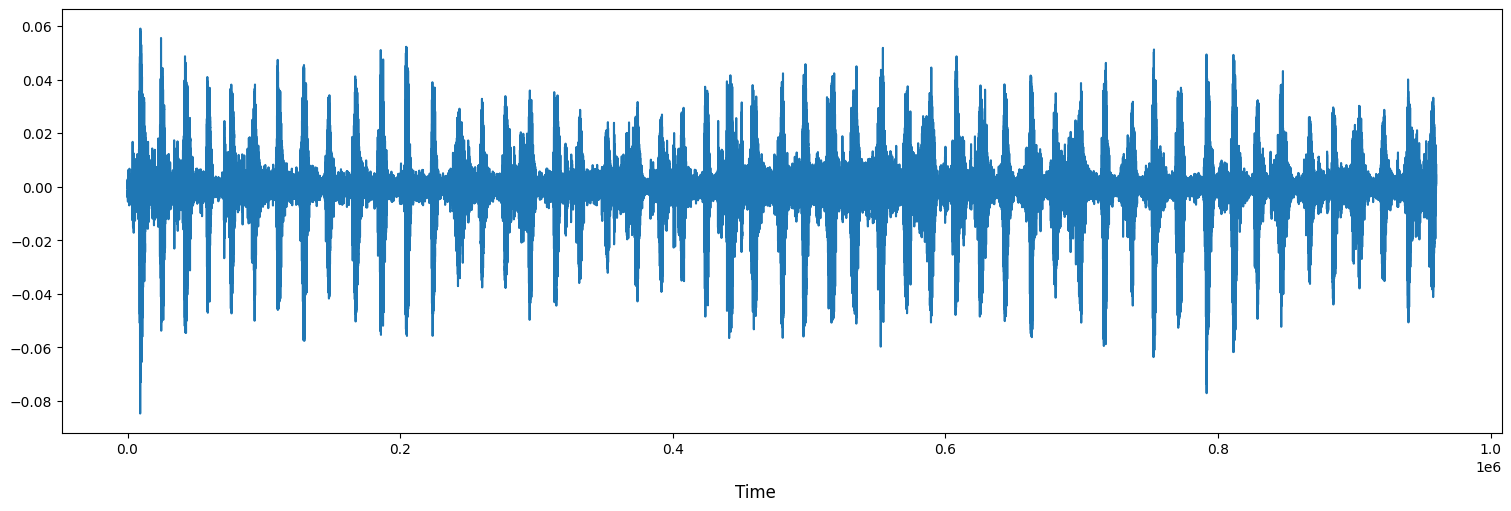

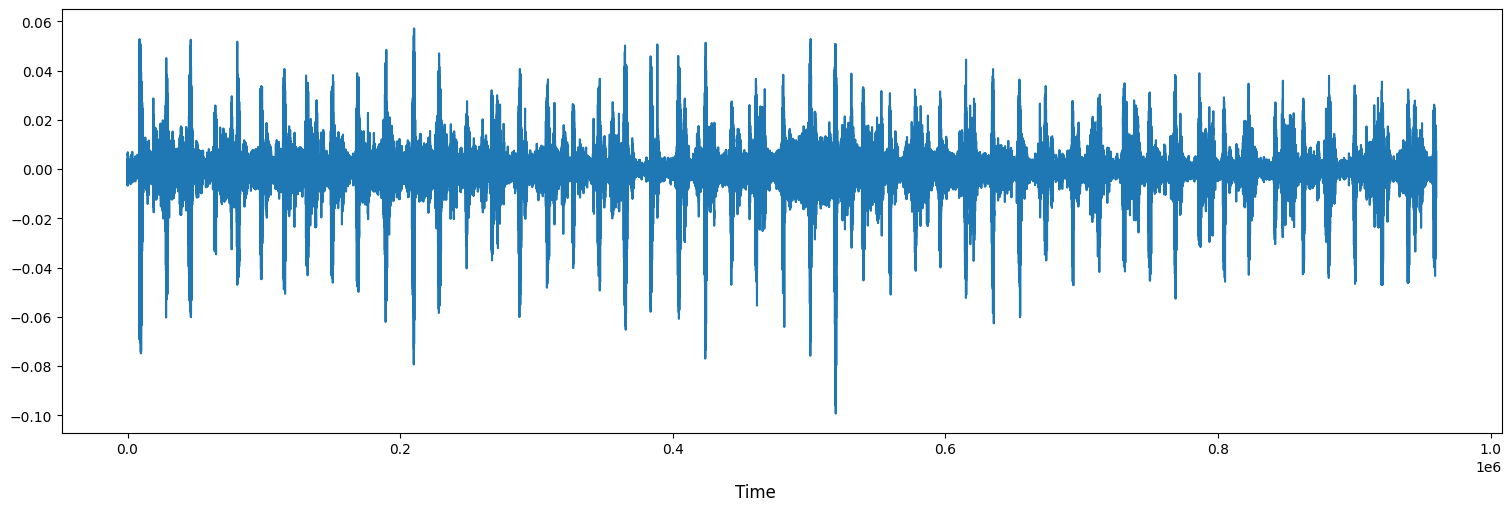

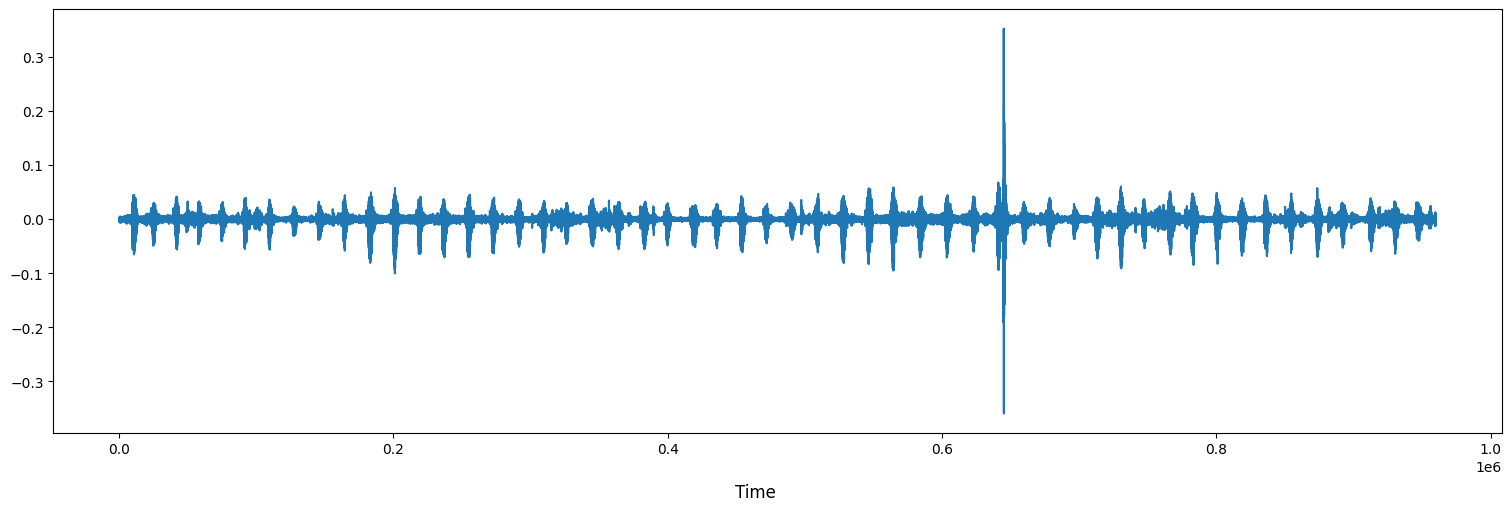

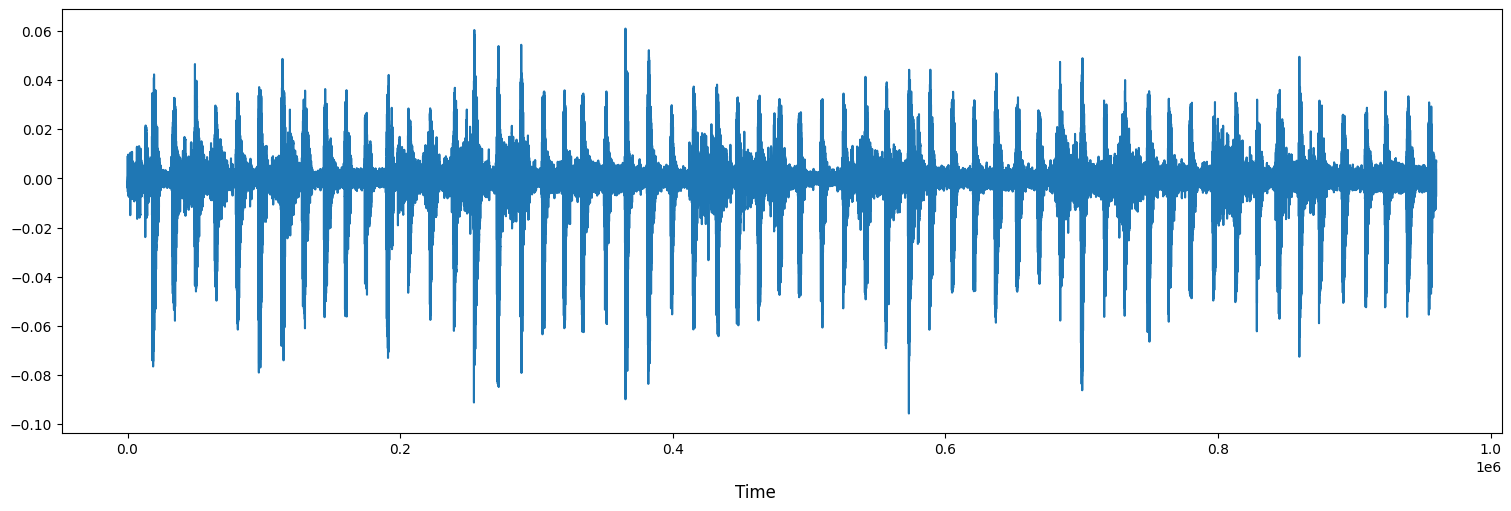

In [7]:
local_set_folder = "./local_recordings/"
alphabets = ['c', 'd', 'h', 'k', 'n', 'o', 'r', 's', 'v', 'z']

for alphabet in alphabets:
    signal, fs = sf.read(local_set_folder + alphabet + '.wav')
    plot_signal_array(signal)
    sf.write(local_set_folder + alphabet + '_sample.wav', signal[100:160*40+100], fs)